# Chapter 18. Neural Networks

In [126]:
from __future__ import division
from collections import Counter
from functools import partial
from linear_algebra import dot
import math, random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

An [artificial neural network](https://en.wikipedia.org/wiki/Artificial_neural_network), also known as an [ANN](https://www.doc.ic.ac.uk/~nd/surprise_96/journal/vol4/cs11/report.html) is a predictive model motivated by the way (some scientists and scholars believe) the brain operates (in theory, anyway).  
Think of the brain as a collection of neurons wired together.  
Each neuron looks at the outputs of the other neurons that feed into it, does a calculation, and then either fires (if the calculation exceeds some threshold) or doesn't fire (if the threshold is not reached).  
ANNs consist of artificial neurons which perform similar calculations over their inputs.  
Neural networks can be used to solve a wide variety of problems including handwriting recognition and face identification, and are also widely used in [deep learning](https://en.wikipedia.org/wiki/Deep_learning).  
Most neural networks are "black boxes", meaning that inspecting their details doesn't give you much understanding of *how* they are solving a problem.  
Large ANNs can also be (very) difficult to train.  
Keeping those caveats in mind, artificial neural networks can be used to do some [amazing stuff](https://gizmodo.com/these-are-the-incredible-day-dreams-of-artificial-neura-1712226908), so let's dive in.

## Perceptrons

Pretty much the simplest neural network is the [perceptron](https://en.wikipedia.org/wiki/Perceptron), which approximates a single neuron with $n$ binary inputs.  
It computes a weighted sum of its inputs and "fires" if that weighted sum is zero or greater:

In [127]:
def step_function(x):
    return 1 if x >= 0 else 0

def perceptron_output(weights, bias, x):
    """ returns 1 if the perceptron 'fires', 0 if not """
    calculation = dot(weights, x) + bias
    return step_function(calculation)

The perceptron is simply distinguishing between the half spaces separated by the hyperplane of points x for which:

With properly chosen weights, perceptrons can solve a number of simple problems:

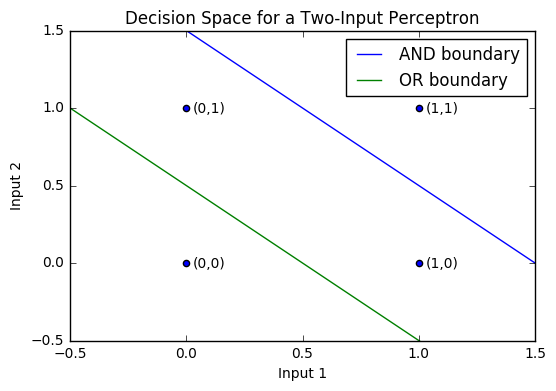

In [128]:
plt.scatter(0,1)
plt.annotate('(0,1)', xy=(0.03,0.97))
plt.scatter(1,0)
plt.annotate('(1,0)', xy=(1.03,-0.03))
plt.scatter(0,0)
plt.annotate('(0,0)', xy=(0.03,-0.03))
plt.scatter(1,1)
plt.annotate('(1,1)', xy=(1.03,0.97))
x1 = np.linspace(0, 1.5, 100)
y1 = np.linspace(1.5, 0, 100)
x2 = np.linspace(-1, 1.5, 100)
y2 = np.linspace(1.5, -1, 100)
plt.plot(x1,y1, label="AND boundary")
plt.plot(x2,y2, label="OR boundary")
plt.axis([-.5, 1.5, -.5, 1.5])
plt.title("Decision Space for a Two-Input Perceptron")
plt.xlabel("Input 1")
plt.ylabel("Input 2")
plt.legend()
plt.show()

For example, we can create an [AND gate](https://en.wikipedia.org/wiki/AND_gate) (which returns 1 if both of its inputs are 1 but returns 0 if either or both of its inputs are 0) with:

In [129]:
# If both inputs are 1, the `calculation` equals 2 + 2 - 3 = 1, and the output is 1:
print perceptron_output([2,2],-3,[1,1])

# If only one of the inputs is 1, the `calculation` equals 2 + 0 - 3 = -1, and the output is 0:
print perceptron_output([2,2],-3,[1,0])
print perceptron_output([2,2],-3,[0,1])

# If both inputs are 0, the `calculation` equals 0 + 0 - 3 = -3, and the output is 0:
print perceptron_output([2,2],-3,[0,0])

1
0
0
0


Similarly, we can build an [OR gate](https://en.wikipedia.org/wiki/OR_gate) with:

We could also build a [NOT gate](https://en.wikipedia.org/wiki/Inverter_%28logic_gate%29) (which has one input and converts 1 to 0 and 0 to 1) with:

However, there are some problems that simply can't be solved by a a single perceptron.  
For example, no matter how hard you try, you cannot use a perceptron to build an [XOR gate](https://en.wikipedia.org/wiki/XOR_gate) that outputs 1 if exactly one of its inputs is 1 and 0 otherwise.  
This is where we start needing more sophisticated (and complicated) neural networks.

You don't need to approximate a neuron in order to build a logic gate:

Like real neurons, artificial neurons become more interesting when you start connecting them together.

## Feed-Forward Neural Networks 

The topology of the brain is enormously complicated, so it's common to approximate it with an idealized [feed-forward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) that consists of discrete layers of neurons, each connected to the next.  
This typically entails:
- an input layer which receives inputs and feeds them forward unchanged, 
- one or more "hidden layers", each of which consists of neurons that take the outputs of the previous layer, performs some calculation, and passes the result to the next layer, 
- and an output layer which produces the final outputs.

Just like the perceptron, each (non-input) neuron has a weight corresponding to each of its inputs and a bias.  
To make our representation simpler, we'll add the bias to the end of our weights vector and give each neuron a [bias input](https://stackoverflow.com/questions/2480650/role-of-bias-in-neural-networks) that always equals 1.  
As with the perceptron, for each neuron we'll sum up the products of its inputs as well as its weights.  
Here, however, rather than outputting the `step_function` applied to that product, we'll output a smooth approximation of the step function known as the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function):

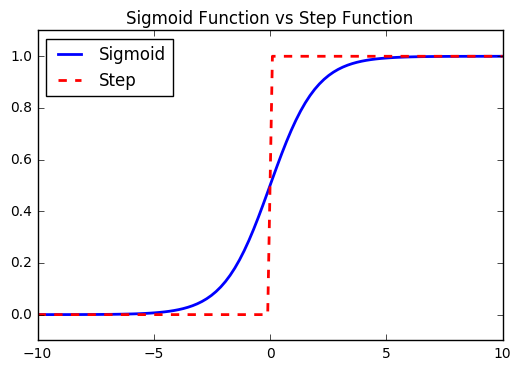

In [130]:
points = np.linspace(-10., 10., 100)
sigmoid = [1 / (1 + math.exp(-point)) for point in points]
step = [(1 if point >= 0 else 0) for point in points]
plt.axis([-10, 10, -0.1, 1.1])
plt.plot(points, sigmoid, lw=2, label="Sigmoid")
plt.plot(points, step, lw=2, ls='--', color='red', label="Step")
plt.title("Sigmoid Function vs Step Function")
plt.legend(loc=2)
plt.show()

In [131]:
def sigmoid(t):
    return 1 / (1 + math.exp(-t))

Why use `sigmoid` instead of the simpler `step_function`?  
In order to train a neural network, we'll need to use calculus, and in order to use calculus, we need *smooth* functions.  
The step function isn't even continuous, and `sigmoid` is a good smooth approximation of it.  
**Note**  
You may remember `sigmoid` from Chapter 16, where it was called `logistic`.  
Technically, 'sigmoid' refers to the *shape* of the function, and 'logistic' refers to that particular function, although the terms are often used interchangeably.

Now we can calculate the output as:

In [132]:
def neuron_output(weights, inputs):
    return sigmoid(dot(weights, inputs))

Given this function, we can represent a neuron simply as a list of weights whose length is one more than the number of inputs to that neuron (remember the bias weight).  
Then we can represent a neural network as a list of (non-input) [layers](http://pages.cs.wisc.edu/~bolo/shipyard/neural/local.html), where each layer is just a list of neurons in that layer.  
In other words, we are oing to represent a neural network as a list (layers) of lists (neurons) of lists (weights).  
Given such a representation, using the neural network is quite simple:

In [133]:
def feed_forward(neural_network, input_vector):
    """ takes in a neural network (represented as a list of lists of lists of weights) """
    """ and returns the output from forward-propagating the inputs """
    outputs = []
    # process one layer at a time
    for layer in neural_network:
        # add a bias input
        input_with_bias = input_vector + [1]
        # compute the output for each neuron
        output = [neuron_output(neuron, input_with_bias) for neuron in layer]
        # and remember it
        outputs.append(output)
        # the input to the next layer is the output of this one
        input_vector = output
    return outputs

Now we can build the XOR gate that we couldn't make with a single perceptron.  
We just need to scale the weights up so that the `neuron_outputs` are either really close to 0 or really close to 1:

In [134]:
xor_network = [# hidden layer
               [[20, 20, -30],    # 'and' neuron
                [20, 20, -10]],   # 'or' neuron
               # output layer
               [[-60, 60, -30]]]  # '2nd input but not 1st input' neuron

for x in [0, 1]:
    for y in [0, 1]:
        # feed_forward produces the outputs of every neuron
        # feed_forward[-1] is the outputs of the output-layer neurons
        print x, y, feed_forward(xor_network,[x, y])[-1]

0 0 [9.38314668300676e-14]
0 1 [0.9999999999999059]
1 0 [0.9999999999999059]
1 1 [9.383146683006828e-14]


By using a hidden layer, we are able to feed the output of an 'and' neuron and the output of an 'or' neuron into a 'second input but not first input' neuron.  
The result is a network that performs 'or, but *not* and,' which is precisely XOR.

![XOR_neural_network](img/XOR_neural_network.png)

## Backpropagation

Neural networks aren't usually built by hand.  
This is in part because they are used to solve much bigger problems, eg. an image recognition program that involves hundreds or even thousands of neurons.  
This is also in part because the programmer won't usually be able to "reason out" what the neurons should be.  
Instead we use data (the more data, the better) to train neural networks.  
One popular approach is an algorithm called [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) that is somewhat similar to the gradient descent algorithm covered in Chapter 8.

Imagine that we have a training set that consists of input vectors and corresponding target output vectors.  
For example, in our previous `xor_network` example, the input vector [1, 0] corresponded to the target output [1].  
Imagine also that our network has some set of weights.  
Those weights are then adjusted using the following algorithm:
1. Run `feed_forward` on an input vector to produce the outputs of all of the neurons in the network.
2. This results in an error for each output neuron -- the difference between its output and its target.
3. Compute the gradient of this error as a function of the neuron's weights, and adjust its weights in the direction that most decreases the error.
4. [Propagate](https://www.merriam-webster.com/dictionary/propagate) these output errors backward to infer errors for the hidden layer.
5. Compute the gradients of these errors and adjust the hidden layer's weights in the same manner.

Typically we run this algorithm many times for our entire training set until the network converges:

In [135]:
# The code in the book is different from the code on the GitHub master.

def backpropagate(network, input_vector, targets):
    hidden_outputs, outputs = feed_forward(network, input_vector)
    # the output * (1 - output) is from the derivative of sigmoid
    output_deltas = [output * (1 - output) * (output - target) for output, target in zip(outputs, targets)]
    
    # adjust weights for the output layer, one neuron at a time
    for i, output_neuron in enumerate(network[-1]):
        # focus on the ith output layer neuron
        for j, hidden_output in enumerate(hidden_outputs + [1]):
            # adjust the jth weight based on both this neuron's delta and its jth input
            output_neuron[j] -= output_deltas[i] * hidden_output
            
    # back-propagate errors to the hidden layer
    hidden_deltas = [hidden_output * (1 - hidden_output)
                     * dot(output_deltas, [n[i] for n in output_layer])
                     for i, hidden_output in enumerate(hidden_outputs)]
    
    # adjust weights for hidden layer, one neuron at a time
    for i, hidden_neuron in enumerate(network[0]):
        for j, input in enumerate(input_vector + [1]):
            hidden_neuron[j] -= hidden_deltas[i] * input

This is pretty much doing the same thing as if you explicitly wrote the squared error as a function of the weights and used the `minimize_stochastic` function that we built in Chapter 8.  
In this case, explicitly writing out the gradient function turns out to be kind of a pain.  
If you know [calculus and the chain rule](https://en.wikipedia.org/wiki/Chain_rule), the mathematical details are fairly straightforward, but keeping the notation straight ("the partial derivative of the error function with respect to the weight that neuron $i$ assigns to the input coming from neuron $j$") can be a bit of a headache.

## Example: Defeating a CAPTCHA

To make sure that people registering for DataSciencester are actually people, the VP of Product Management wants to implement a CAPTCHA as part of the registration process.  
In particular, he would like to show users a picture of a digit and require them to input that digit to prove that they're human.  
When you tell the VP that computers can easily solve this problem and he doesn't believe you, you decide to convince him by creating a program that can defeat CAPTCHAs.

Each digit (0-9 below) will be represented as a 5x5 image:

Our neural network wants an input to be a vector of numbers, so we'll transform each image to a vector of length 25 whose elements are either 1 (this pixel is in the image) or 0 (this pixel is not in the image).  
For example, the zero digit would be represented as:

In [136]:
zero_digit = [1,1,1,1,1,
              1,0,0,0,1,
              1,0,0,0,1,
              1,0,0,0,1,
              1,1,1,1,1]

We want our output to indicate which digit the neural network *thinks* it is, so we'll need 10 outputs (0-9).  
The correct output for digit 4, for instance, will be:

In [137]:
# the zeros in raw_digits have been replaced with periods to make the numbers (slightly) easier for people to read
raw_digits = [
          """11111
             1...1
             1...1
             1...1
             11111""",

          """..1..
             ..1..
             ..1..
             ..1..
             ..1..""",

          """11111
             ....1
             11111
             1....
             11111""",

          """11111
             ....1
             11111
             ....1
             11111""",

          """1...1
             1...1
             11111
             ....1
             ....1""",

          """11111
             1....
             11111
             ....1
             11111""",

          """11111
             1....
             11111
             1...1
             11111""",

          """11111
             ....1
             ....1
             ....1
             ....1""",

          """11111
             1...1
             11111
             1...1
             11111""",

          """11111
             1...1
             11111
             ....1
             11111"""]

def make_digit(raw_digit):
    return [1 if c == '1' else 0 for row in raw_digit.split("\n") for c in row.strip()]

inputs = map(make_digit, raw_digits)

Then, assuming that our `inputs` are correctly ordered from 0 to 9, out targets will be:

In [138]:
targets = [[1 if i == j else 0 for i in range(10)] for j in range(10)]

At which point we're ready to build our neural network:

In [139]:
random.seed(0)
input_size = 25  # each input is a vector of length 25
num_hidden = 5   # 5 neurons in the hidden layer
output_size = 10 # 10 outputs for each input

# each hidden neuron has one weight per input, plus a bias weight
hidden_layer = [[random.random() for __ in range(input_size + 1)] for __ in range(num_hidden)]

# each output neuron has one weight per hidden neuron, plus a bias weight
output_layer = [[random.random() for __ in range(num_hidden + 1)] for __ in range(output_size)]

# the network starts out with random weights
network = [hidden_layer, output_layer]

Now we can train our ANN using the backpropagation algorithm:

In [140]:
# 10,000 iterations seems enough to converge
for __ in range(10000):
    for input_vector, target_vector in zip(inputs, targets):
        backpropagate(network, input_vector, target_vector)

It works well on the training set, obviously:

In [141]:
def predict(input):
    result = feed_forward(network, input)[-1]
    return [round(n,3) for n in result]
predict(inputs[7])

[0.025, 0.0, 0.0, 0.018, 0.001, 0.0, 0.0, 0.967, 0.0, 0.0]

The digit 7 output neuron produces 0.967, while all of the other output neurons produce very small numbers.  
Let's see how our ANN fares with all `raw_digits` 0-9:

In [142]:
for i, input in enumerate(inputs):
    outputs = predict(input)
    print i, [round(p,3) for p in outputs]

0 [0.959, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.024, 0.029, 0.0]
1 [0.0, 0.961, 0.031, 0.021, 0.003, 0.0, 0.0, 0.0, 0.0, 0.0]
2 [0.0, 0.022, 0.96, 0.0, 0.003, 0.027, 0.0, 0.0, 0.0, 0.0]
3 [0.0, 0.029, 0.0, 0.971, 0.0, 0.0, 0.0, 0.019, 0.0, 0.03]
4 [0.0, 0.016, 0.005, 0.0, 0.985, 0.0, 0.0, 0.007, 0.0, 0.0]
5 [0.0, 0.0, 0.023, 0.0, 0.0, 0.962, 0.008, 0.0, 0.015, 0.019]
6 [0.0, 0.0, 0.012, 0.0, 0.013, 0.015, 0.991, 0.0, 0.008, 0.0]
7 [0.025, 0.0, 0.0, 0.018, 0.001, 0.0, 0.0, 0.967, 0.0, 0.0]
8 [0.032, 0.0, 0.0, 0.0, 0.0, 0.012, 0.002, 0.0, 0.96, 0.03]
9 [0.0, 0.0, 0.0, 0.012, 0.0, 0.022, 0.0, 0.0, 0.024, 0.955]


We can also apply our neural network to differently drawn digits, like the author's stylized 3:

In [143]:
predict([0,1,1,1,0,  # .@@@.
         0,0,0,1,1,  # ...@@
         0,0,1,1,0,  # ..@@.
         0,0,0,1,1,  # ...@@
         0,1,1,1,0]) # .@@@. 

[0.0, 0.002, 0.0, 0.934, 0.0, 0.0, 0.0, 0.007, 0.0, 0.1]

The network still thinks it looks like a 3, whereas the author's stylized 8 gets votes for being a 5, an 8, and a 9:

In [144]:
predict([0,1,1,1,0,  # .@@@.
         1,0,0,1,1,  # @..@@
         0,1,1,1,0,  # .@@@.
         1,0,0,1,1,  # @..@@
         0,1,1,1,0]) # .@@@. 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.536, 0.0, 0.0, 0.915, 0.996]

Having a larger training set would probably help.

## Visualization Time

Although the network's operation is not exactly transparent, we can inspect the weights of the hidden layer to get a sense of what they are 'seeing'.  
In particular, we can plot the weights of each neuron as a 5x5 grid corresponding to the 5x5 inputs.  
In real life we would probably want to plot zero weights as white, with larger positive weights more and more (say) green and larger negative weights more and more (say) red.  
Instead, we'll plot zero weights as white, with far-away-from-zero weights darker and darker.  
Crosshatching will indicate negative weights.  
To do this we'll use `pyplot.imshow`, which we can use to plot images pixel by pixel.  
Normally this isn't very useful for data science, but for our learning purposes it's a good choice.

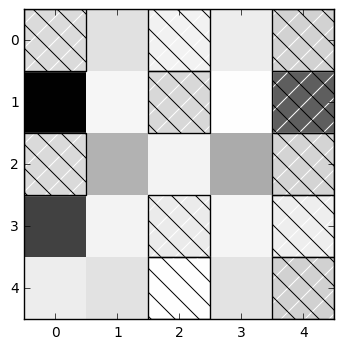

In [145]:
import matplotlib

weights = network[0][0]   # try this with network[0][0], ..., network[0][4], or you can subplot them all
abs_weights = map(abs, weights)   # darkness only depends on absolute value

# turn the weights into a 5x5 grid with [weights[0:5], ..., [weights[20:25]]]
grid = [abs_weights[row:(row+5)] for row in range(0,25,5)]
ax = plt.gca()   # to use hatching, we'll need the axis

# next is the same as plt.imshow, using a white-black color scale and plotting the blocks as blocks
ax.imshow(grid, cmap=matplotlib.cm.binary, interpolation='none')

def patch(x, y, hatch, color):
    """return a matplotlib 'patch' object with the specified
    location, crosshatch pattern, and color"""
    return matplotlib.patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                        hatch=hatch, fill=False, color=color)

# cross-hatch the negative weights
for i in range(5):                    # row
    for j in range(5):                # column
        if weights[5*i + j] < 0:      # row i, column j = weights[5*i + j]
            # add black and white hatches, so visible whether dark or light
            ax.add_patch(patch(j, i, '/',  "white"))
            ax.add_patch(patch(j, i, '\\', "black"))

plt.show()

Notice that the first hidden neuron (`network[0][0]`) large positive weights in the left column and on either side of the center in the middle row, while there are large negative weights in the right column.  
This neuron has a pretty large negative bias, which means that it won't fire strongly unless it gets precisely the positive inputs it's 'looking for'.  
For those inputs, the neuron does what you would expect:

In [146]:
left_column_only = [1, 0, 0, 0, 0] * 5
print feed_forward(network, left_column_only)[0][0]

0.999959524615


In [147]:
center_middle_row = [0, 0, 0, 0, 0] * 2 + [0, 1, 1, 1, 0] + [0, 0, 0, 0, 0] * 2
print feed_forward(network, center_middle_row)[0][0]

0.954107627065


In [148]:
right_column_only = [0, 0, 0, 0, 1] * 5
print feed_forward(network, right_column_only)[0][0]

8.71509188498e-09


Notice how the middle hidden neuron (`network[0][2]`) seems to 'like' horizontal lines but not side vertical lines, and the last hidden neuron (`network[0][4]`) seems to 'like' the center row but not the right column.  
The other two neurons are a bit more difficult to interpret, but see what they can 'tell' you.

What happens when we run the author's stylized 3 through the network?

In [149]:
my_three =  [0,1,1,1,0,  # .@@@.
             0,0,0,1,1,  # ...@@
             0,0,1,1,0,  # ..@@.
             0,0,0,1,1,  # ...@@
             0,1,1,1,0]  # .@@@.

hidden, output = feed_forward(network, my_three)

The hidden outputs are:

In [150]:
hidden  # show results from network[0][0], ..., network[0][4]

[0.10387769329168753,
 0.9999785242978947,
 0.9999999993558526,
 0.9999921711029089,
 3.1767927409496455e-07]

which enter into the 'three' output neuron with weights `network[-1][3]`:

In [151]:
network[-1][3]

[-11.527644390098375,
 -2.178890476966917,
 9.362089906951441,
 -1.3913205450697117,
 -11.547190694429755,
 -1.9376884722879057]

Based on the output above, the neuron is going to compute:

In [152]:
sigmoid(.104 * -11.53 + 1 * -2.18 + 1 * 9.36 + 1 * -1.39 + 0 * -11.54 - 1.95)

0.933446654399999

which is (very close to, anyway) the result for output neuron for the number 3.

In [153]:
print output

[1.0101045598243533e-08, 0.001726887935497551, 1.78191113310607e-08, 0.9344276025778887, 5.097944343977291e-07, 3.6294250408123e-06, 2.2726529247374686e-10, 0.007047567870016199, 3.9216678958134186e-08, 0.09973408445781098]


In [154]:
print output[3]

0.934427602578


In essence, the hidden layer is calculating five different partitions of 25-dimensional space, mapping each 25-dimensional output down to five numbers.  
Then each output neuron looks only at the results of those five partitions.  
As we saw, `my_three` falls slightly on the 'low' side of partition 0 (meaning that it only slightly activates hidden neuron 0), far on the 'high' side of partitions 1, 2, and 3 (it strongly activates those hidden neurons), and far on the low side of partition 4 (it doesn't activate that neuron at all.  
Finally, each of the 10 output neurons uses only those five activations to decide whether `my_three` is their digit or not.

## For Further Exploration

- Coursera has a class on [Neural Networks for Machine Learning](https://www.coursera.org/learn/neural-networks) taught by Geoffrey Hinton. The class was last run in 2012, but the course materials are still available.
- Michael Nielsen has written an online book on [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/).
- [PyBrain](http://pybrain.org/) is a fairly simple Python neural network library.
- [Keras](https://keras.io/) is a high-level neural networks library written in Python that runs on top of [TensorFlow](https://github.com/tensorflow/tensorflow) or [Theano](https://github.com/Theano/Theano).
- [Pylearn2](http://deeplearning.net/software/pylearn2/) is a much more advanced (and harder to use) neural network library.